# Imports

In [1]:
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
import random


# Question 3: The Evolution of Random Networks & Phase Transitions

## General Helpers

In [13]:
def generate_k_values():
    k1 = np.arange(0.0, 0.8, 0.1)
    k2 = np.arange(0.8, 1.2, 0.02)  
    k3 = np.arange(1.2, 5.01, 0.1)
    return np.unique(np.concatenate([k1, k2, k3]))

def measure_graph(N, k_avg):
    p = k_avg / (N - 1)
    G = ig.Graph.Erdos_Renyi(n=N, p=p, directed=False)
    components = G.clusters()
    sizes = np.array(components.sizes())
    NG = sizes.max()
    S = NG / N
    finite_sizes = sizes[sizes < NG]
    if len(finite_sizes) > 0:
        avg_s = finite_sizes.mean()
    else:
        avg_s = 0.0

    return S, avg_s


def simulate_ER_phase_transition(N=1000, realizations=50):
    k_values = generate_k_values()
    S_mean = []
    s_mean = []
    for k in k_values:
        S_vals = []
        s_vals = []
        for _ in range(realizations):
            S, avg_s = measure_graph(N, k)
            S_vals.append(S)
            s_vals.append(avg_s)
        S_mean.append(np.mean(S_vals))
        s_mean.append(np.mean(s_vals))
    return k_values, np.array(S_mean), np.array(s_mean)



## Part a&b

### Simulation

C:\Users\Admin\AppData\Local\Temp\ipykernel_15760\3889159355.py:10: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  components = G.clusters()


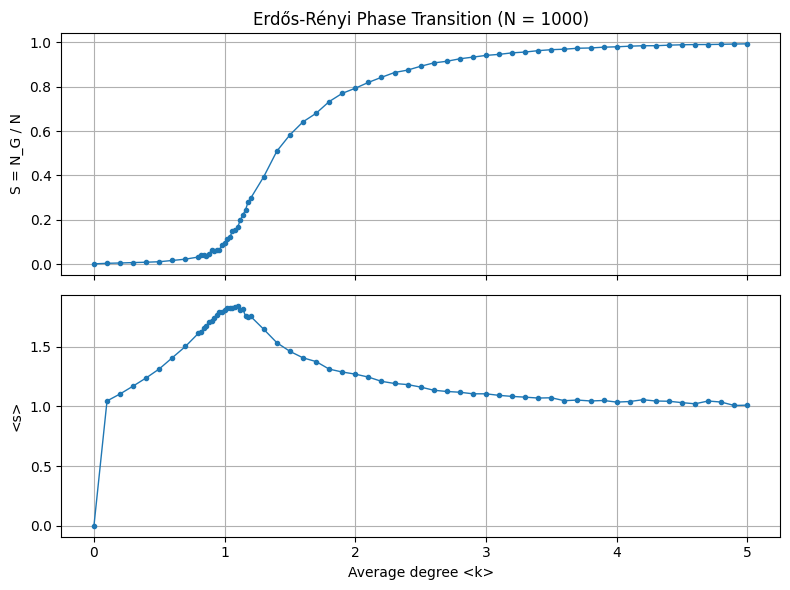

In [7]:
k_vals, S_vals, s_vals = simulate_ER_phase_transition()

fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True,figsize=(8, 6))

ax1.plot(k_vals, S_vals, marker='o', markersize=3, linewidth=1)
ax1.set_ylabel(r"S = N_G / N")
ax1.set_title("Erdős-Rényi Phase Transition (N = 1000)")
ax1.grid(True)

ax2.plot(k_vals, s_vals, marker='o', markersize=3, linewidth=1)
ax2.set_xlabel(r"Average degree <k>")
ax2.set_ylabel(r"<s>")
ax2.grid(True)

plt.tight_layout()
plt.show()



## Part C: Finite Size Effects

In [8]:
Ns = [100, 1000, 10000]
results = {}

for N in Ns:
    k_vals, S_vals, s_vals = simulate_ER_phase_transition(
        N=N,
        realizations=50
    )
    results[N] = (k_vals, S_vals, s_vals)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15760\3889159355.py:10: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  components = G.clusters()


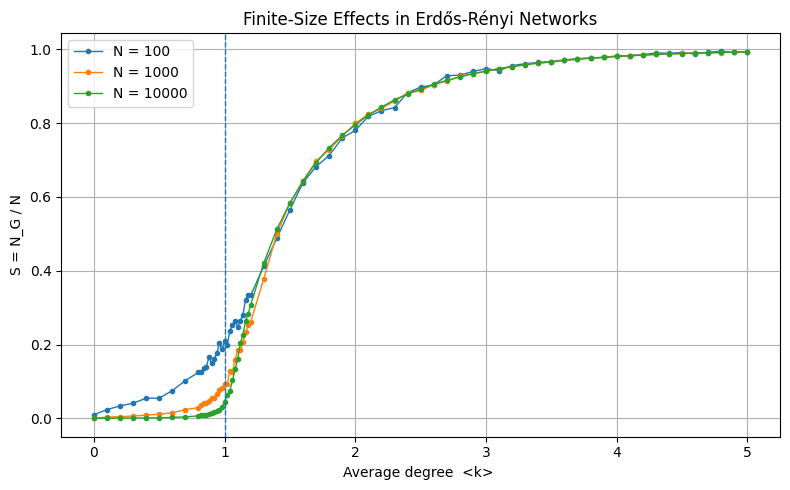

In [9]:
plt.figure(figsize=(8, 5))

for N in Ns:
    k_vals, S_vals, _ = results[N]
    plt.plot(k_vals, S_vals, marker='o', markersize=3, linewidth=1, label=f"N = {N}")

plt.axvline(1.0, linestyle='--', linewidth=1)
plt.xlabel(r"Average degree  <k> ")
plt.ylabel(r"S = N_G / N")
plt.title("Finite-Size Effects in Erdős-Rényi Networks")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Part D The Critical State

### Helper

In [24]:
def log_binning(data, num_bins=25):
    data = np.asarray(data)
    data = data[data > 0]  # remove non-positive values

    s_min = data.min()
    s_max = data.max()

    bin_edges = np.logspace(np.log10(s_min), np.log10(s_max), num_bins + 1)

    bin_centers = []
    P_s = []

    total = len(data)

    for i in range(num_bins):
        left = bin_edges[i]
        right = bin_edges[i + 1]

        mask = (data >= left) & (data < right)
        count = np.sum(mask)

        if count > 0:
            bin_width = right - left
            P_s.append(count / (total))
            bin_centers.append(np.sqrt(left * right))

    return np.array(bin_centers), np.array(P_s)


### Simulation

In [38]:
N = 10_000
k_avg = 1.0
p = k_avg / (N - 1)

G = ig.Graph.Erdos_Renyi(n=N, p=p, directed=False)

components = G.clusters()
sizes = np.array(components.sizes())
s_vals, P_s = log_binning(sizes, 100)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15760\2045248721.py:7: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  components = G.clusters()


Estimated power-law exponent alpha ≈ 1.51


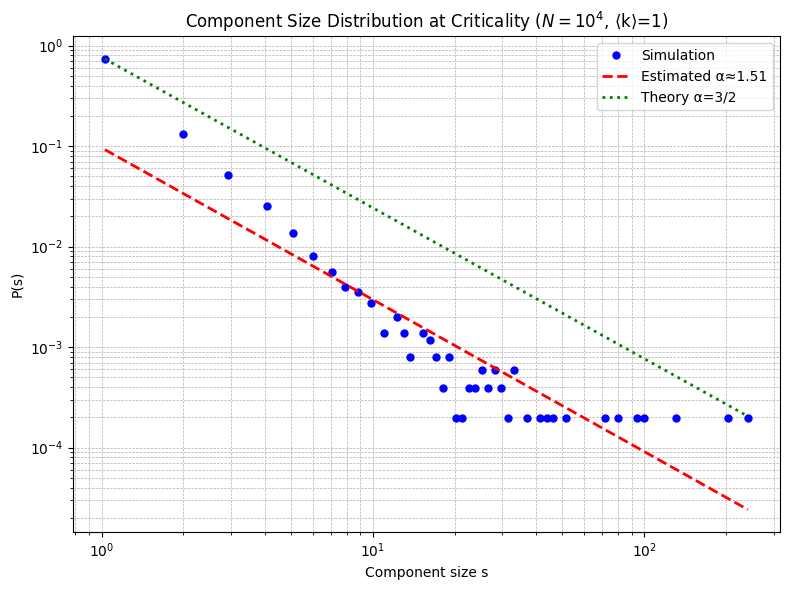

In [39]:
tail_mask = s_vals > 0
log_s = np.log10(s_vals[tail_mask])
log_P = np.log10(P_s[tail_mask])
coeffs = np.polyfit(log_s, log_P, 1)
alpha_est = -coeffs[0]
print(f"Estimated power-law exponent alpha ≈ {alpha_est:.2f}")

# Generate lines for visualization
s_fit = np.linspace(min(s_vals[tail_mask]), max(s_vals[tail_mask]), 100)
P_est_line = 10**(coeffs[1]) * s_fit**(-alpha_est)  # estimated line
P_theory_line = P_s[tail_mask][0] * (s_fit / s_fit[0])**(-1.5)  # theoretical α=3/2

# Plot
plt.figure(figsize=(8,6))
plt.loglog(s_vals, P_s, 'bo', markersize=5, label='Simulation')
plt.loglog(s_fit, P_est_line, 'r--', linewidth=2, label=f'Estimated α≈{alpha_est:.2f}')
plt.loglog(s_fit, P_theory_line, 'g:', linewidth=2, label=r'Theory α=3/2')
plt.xlabel("Component size s")
plt.ylabel("P(s)")
plt.title("Component Size Distribution at Criticality ($N=10^4$, ⟨k⟩=1)")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.tight_layout()
plt.show()
